In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

data = pd.read_csv("../stats.csv")
data.head()

,"last_name, first_name",player_id,year,player_age,ab,pa,hit,single,double,triple,...,exit_velocity_avg,launch_angle_avg,sweet_spot_percent,barrel_batted_rate,hard_hit_percent,avg_best_speed,avg_hyper_speed,whiff_percent,swing_percent,sprint_speed
0,"Ortiz, David",120074,2016,40,537,626,169,82,48,1,...,93.2,16.9,39.3,15.5,47.2,103.045534,96.143184,19.4,43.5,23.6
1,"Beltré, Adrian",134181,2016,37,583,640,175,111,31,1,...,90.1,14.5,34.2,8.5,40.4,99.676160,94.135211,15.2,48.7,25.9
2,"Beltrán, Carlos",136860,2016,39,552,593,163,101,33,0,...,90.1,12.6,32.5,6.8,38.5,100.288108,94.247053,19.6,45.6,25.7
3,"Werth, Jayson",150029,2016,37,525,606,128,79,28,0,...,91.4,15.0,31.9,7.4,44.6,101.514040,95.154871,20.9,38.1,25.8
4,"Martinez, Victor",400121,2016,37,553,610,160,111,22,0,...,90.0,15.5,37.8,8.4,42.1,99.515406,94.050070,17.2,46.4,22.6


In [2]:
data.drop(columns=["avg_swing_speed", "fast_swing_rate", "blasts_contact", "blasts_swing", "squared_up_contact", "squared_up_swing", "avg_swing_length", "swords", "on_base_plus_slg", "woba", "slg_percent", "on_base_percent", "xba", "xwoba", "xslg", "xiso", "xobp"], inplace=True)
numeric_cols = data.select_dtypes(include=["int64", "float64"]).columns
correlations = data[numeric_cols].corr()["r_run"].sort_values(ascending=False)
correlations.drop(index="r_run", inplace=True)

# 득점과의 상관관계
print("득점과의 상관관계:")
print(correlations)

corr_top11 = correlations.head(11)

득점과의 상관관계:
pa                    0.838064
hit                   0.829575
ab                    0.799364
b_foul                0.739770
b_rbi                 0.738244
double                0.704050
home_run              0.667743
walk                  0.652585
single                0.624288
strikeout             0.525097
b_swinging_strike     0.471412
batting_avg           0.344208
triple                0.316849
exit_velocity_avg     0.244608
barrel_batted_rate    0.226386
avg_hyper_speed       0.220866
avg_best_speed        0.219714
bb_percent            0.201104
sprint_speed          0.196441
hard_hit_percent      0.195320
babip                 0.193092
sweet_spot_percent    0.167617
launch_angle_avg      0.106190
player_id             0.013376
year                 -0.040819
player_age           -0.075862
whiff_percent        -0.090569
swing_percent        -0.097844
k_percent            -0.098728
Name: r_run, dtype: float64


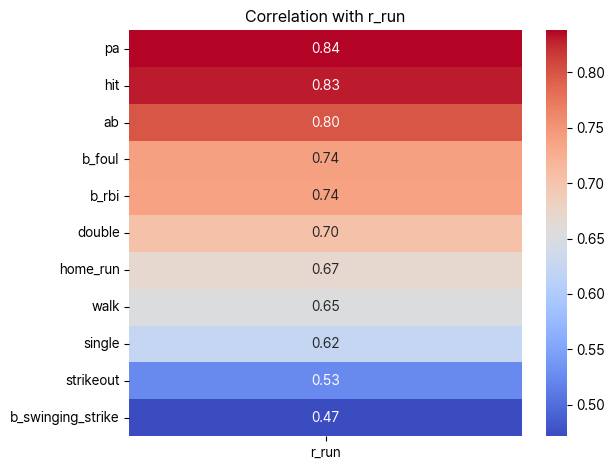

In [3]:
plt.rcParams["font.family"] = "Pretendard"
# 상관관계 히트맵
sns.heatmap(corr_top11.to_frame(),
            annot=True,
            fmt=".2f", 
            cmap="coolwarm",
            cbar=True)

plt.title("Correlation with r_run")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

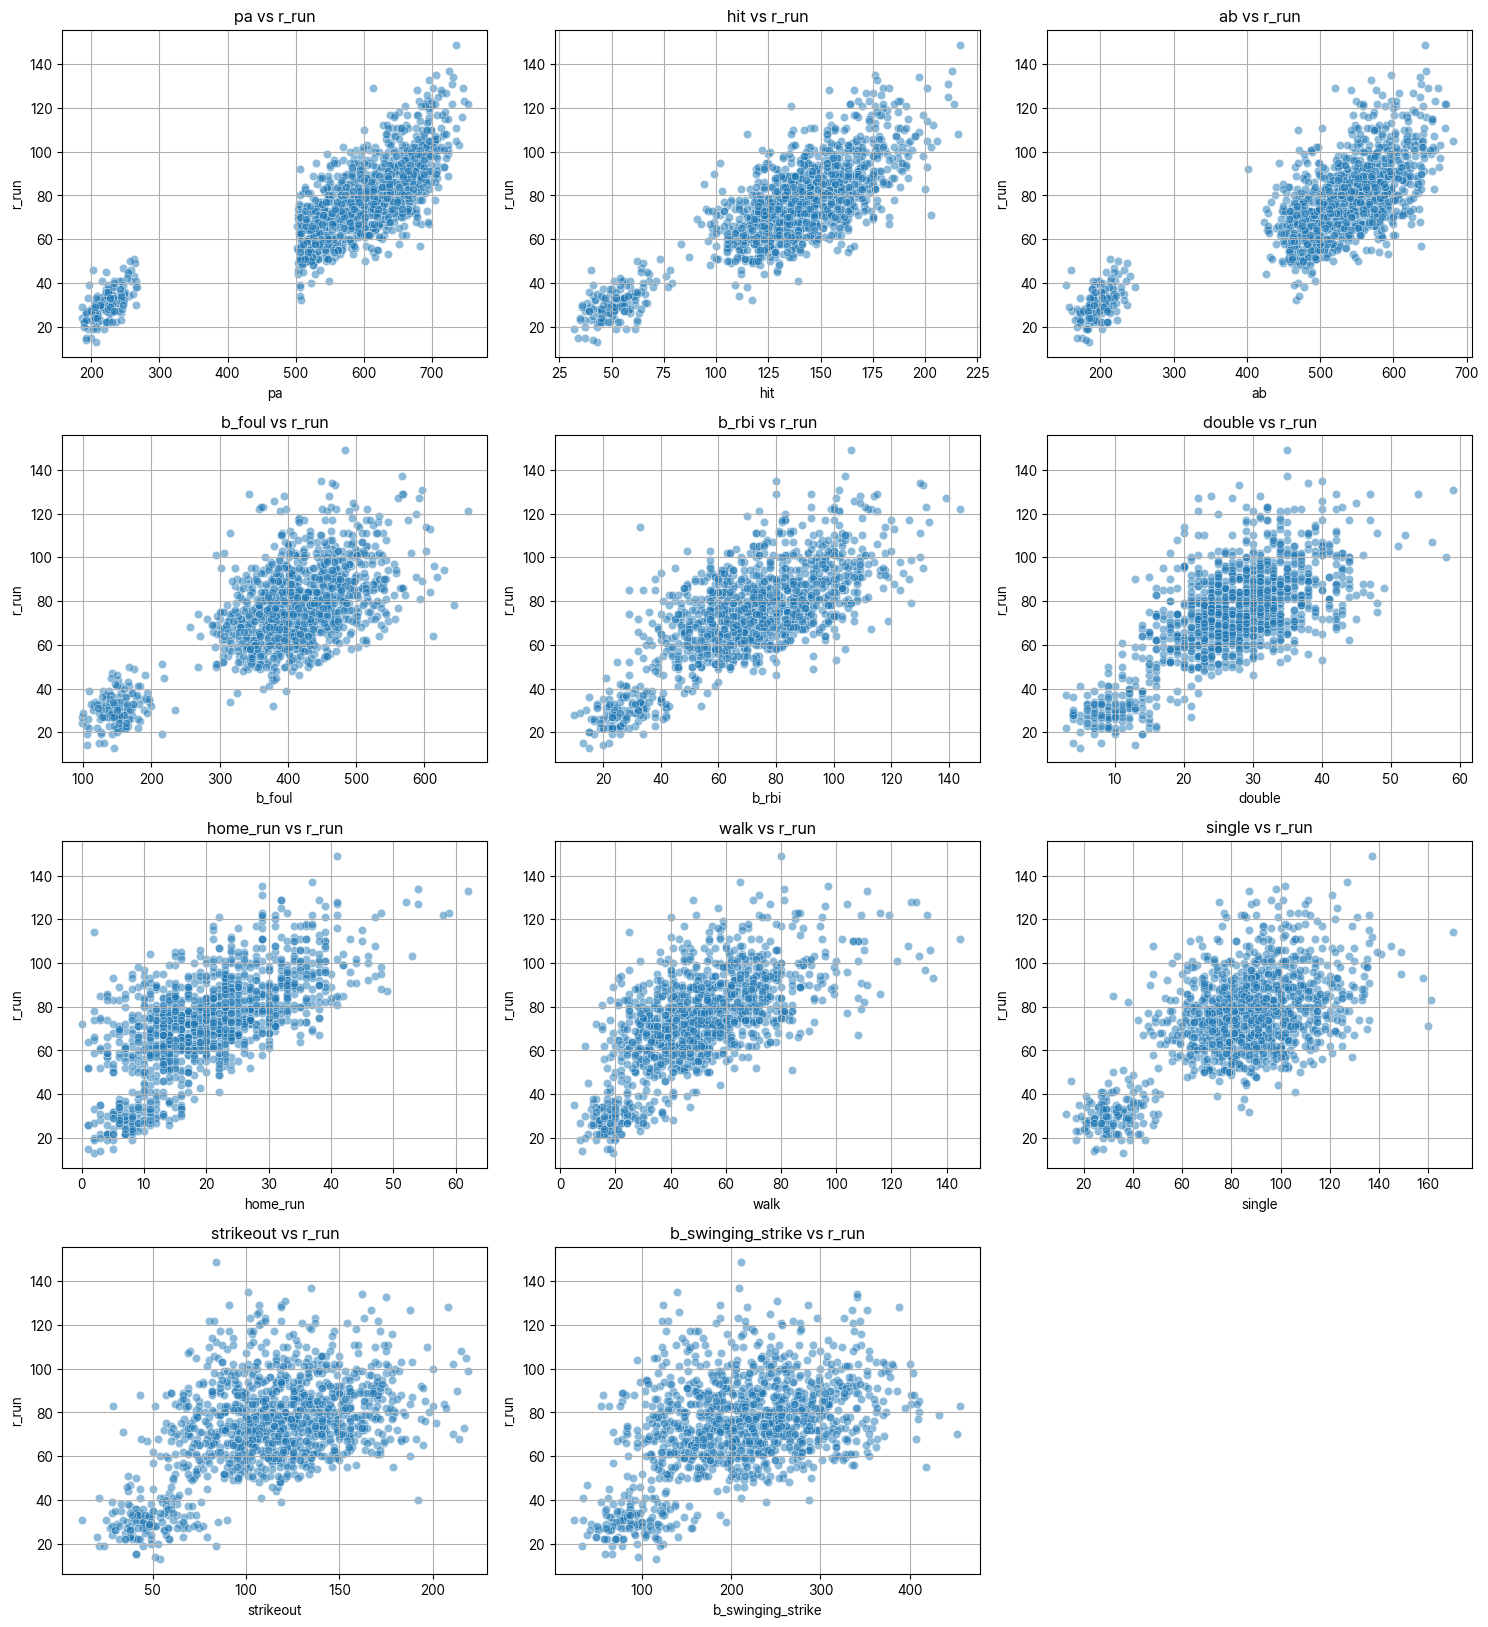

In [4]:
target = "r_run"
n_rows = 5
n_cols = 3

plt.figure(figsize=(15, 4 * n_rows))

for i, var in enumerate(corr_top11.index, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.scatterplot(x=data[var], y=data[target], alpha=0.5)
    plt.title(f"{var} vs {target}")
    plt.xlabel(var)
    plt.ylabel(target)
    plt.grid(True)

plt.tight_layout()
plt.show()

### 합성변수를 제외한 주요 지표 11개
- ab: 타수
- pa: 타석 수
- hit: 안타 수
- b_foul: 파울 수
- b_rbi: 타점 수
- double: 2루타 개수
- home_run: 홈런 개수
- walk: 볼넷 개수
- single: 1루타 개수
- strikeout: 삼진 개수
- b_swinging_strike: 스윙 삼진 개수

In [5]:
from scipy.stats import shapiro, levene, ttest_ind, ranksums

def perform_hypothesis_testing(data, feature, target):
    median_value = data[feature].median()
    high_group = data[data[feature] > median_value][target]
    low_group = data[data[feature] <= median_value][target]
    
    # 정규성 검정
    _, p_high_normal = shapiro(high_group)
    _, p_low_normal = shapiro(low_group)
    
    # 등분산성 검정
    _, p_equal_var = levene(high_group, low_group)
    
    # 검정 방법 선택 및 수행
    if p_high_normal > 0.05 and p_low_normal > 0.05 and p_equal_var > 0.05:
        stat, p_value = ttest_ind(high_group, low_group, equal_var=True)
        test_used = "t-test"
    else:
        stat, p_value = ranksums(high_group, low_group)
        test_used = "wilcoxon rank-sum test"
    
    # 그룹별 평균값 계산
    high_mean = high_group.mean()
    low_mean = low_group.mean()
    
    return {
        "feature": feature,
        "test Used": test_used,
        "statistic": stat,
        "p-value": p_value,
        "high group mean": high_mean,
        "low group mean": low_mean,
        "mean difference": high_mean - low_mean
    }

# 가설 검정 수행
results = []
for feature in corr_top11.index:
    result = perform_hypothesis_testing(data, feature, target)
    results.append(result)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values("p-value")
results_df

,feature,test Used,statistic,p-value,high group mean,low group mean,mean difference
0,pa,wilcoxon rank-sum test,23.241471,1.735110e-119,87.931485,59.287097,28.644388
2,ab,wilcoxon rank-sum test,21.518676,1.040925e-102,87.013008,60.108414,26.904594
1,hit,wilcoxon rank-sum test,21.234093,4.625356e-100,87.059308,60.407348,26.651960
6,home_run,wilcoxon rank-sum test,19.751302,7.817600e-87,86.487479,61.283912,25.203567
4,b_rbi,wilcoxon rank-sum test,19.400717,7.610214e-84,86.045603,61.111470,24.934132
7,walk,wilcoxon rank-sum test,17.887534,1.474922e-71,85.276490,62.246423,23.030067
5,double,wilcoxon rank-sum test,17.696304,4.477424e-70,85.249584,62.381329,22.868255
3,b_foul,wilcoxon rank-sum test,16.403361,1.809441e-60,84.265472,62.877221,21.388251
8,single,wilcoxon rank-sum test,12.786464,1.951517e-37,82.660626,64.672524,17.988102
9,strikeout,wilcoxon rank-sum test,11.391675,4.600596e-30,81.352365,65.791935,15.560430


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

X = data[corr_top11.index]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print("성능:")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")
print(f"Adjusted R2: {adjusted_r2:.2f}")
print()

# 각 특성의 계수와 중요도 확인
feature_importance = pd.DataFrame({
    "feature": corr_top11.index,
    "coefficient": model.coef_
})
feature_importance = feature_importance.sort_values("coefficient", key=abs, ascending=False)

print("feature 중요도:")
feature_importance.reset_index(drop=True)

성능:
RMSE: 8.04
R2 Score: 0.87
Adjusted R2: 0.86

feature 중요도:


,feature,coefficient
0,hit,1.674004
1,single,-1.296948
2,double,-1.104414
3,home_run,-0.346459
4,ab,-0.269396
5,pa,0.261296
6,b_rbi,-0.210254
7,strikeout,0.019702
8,b_swinging_strike,-0.012290
9,b_foul,-0.001537


In [7]:
ohtani = data[data["last_name, first_name"].str.contains("Ohtani")]
ohtani

,"last_name, first_name",player_id,year,player_age,ab,pa,hit,single,double,triple,...,exit_velocity_avg,launch_angle_avg,sweet_spot_percent,barrel_batted_rate,hard_hit_percent,avg_best_speed,avg_hyper_speed,whiff_percent,swing_percent,sprint_speed
811,"Ohtani, Shohei",660271,2021,26,537,639,138,58,26,8,...,93.6,16.6,35.4,22.3,53.6,105.900177,97.802022,35.1,45.8,28.8
933,"Ohtani, Shohei",660271,2022,27,586,666,160,90,30,6,...,92.9,12.1,35.0,16.8,49.8,103.823624,96.520364,28.1,49.3,28.2
1041,"Ohtani, Shohei",660271,2023,28,497,599,151,73,26,8,...,94.4,13.2,35.6,19.6,54.2,105.748559,97.769058,32.3,48.2,27.8
1157,"Ohtani, Shohei",660271,2024,29,636,731,197,98,38,7,...,95.8,16.2,37.8,21.5,60.1,106.727792,98.772122,29.8,47.3,28.1


In [8]:
X_ohtani = ohtani.iloc[0:1][corr_top11.index] # 2021년 오타니
y_ohtani = ohtani.iloc[0][target]

predict = model.predict(X_ohtani)
print(f"predict: {predict[0]:.2f}")
print(f"actual: {y_ohtani:.2f}")

predict: 110.09
actual: 103.00
